<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/main/Copia_de_proyect_lau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyect: Characterizing the flow of different fuels in the nozzle of a compression ignition engine's inyector**
**Professor: Johan Hoffman**

Student: Laura Plazas García

# **Abstract**

The objective of this report is to investigate fuel injection within the nozzle of a compression ignition engine's injection system, as well as to analyze the flow characteristics of various fuels. Our approach involves reconstructing the nozzle geometry and developping a finite element method (FEM) model. This model enables us to explore the impact of different fuels on injection quality by treating the problem as a convection-diffusion phenomenon.


This short report show an example on how to use FEniCS to solve a heat convection-diffusion problem, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2024 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

#from dolfin import NeumannBC

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

# Heat convection equations

$\dot u + (u\cdot \nabla)u + \nabla p = 0, \quad \nabla \cdot u = 0, \quad \dot w + \nabla \cdot (w u) - \epsilon \Delta w = 0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve a **heat convection problem in 2D**. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p,w)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p, \nabla \cdot v) + (\nabla \cdot u, q) + (\dot w + (\nabla \cdot (w u), q) + (\epsilon \nabla w, \nabla q)+ SD(u,p,w;v,q,z) = 0,$

for all test functions $(v,q,z) \in \hat V\times \hat Q$, where $SD(u,p,w;v,q,z)$ is a residual based stabilization term.


# **Method**

**Define domain and mesh**

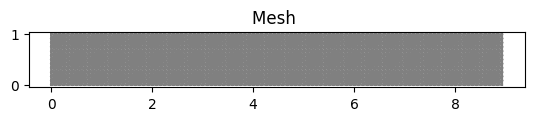

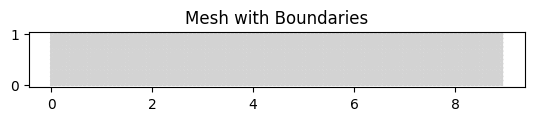

In [ ]:
# Define rectangular domain (modified for 1x0.112 mm) --> ADIMENSIONAL
L = 1.0/0.112
H = 0.112/0.112

# Define opening size (third of the side length)
opening_size = H / 3

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) and on_boundary

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L) and on_boundary

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0) and on_boundary

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H) and on_boundary

class Opening(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[0], 0.0) and (x[1] > opening_size) and on_boundary) or \
               (near(x[0], 0.0) and (x[1] < 3*opening_size) and on_boundary)

left = Left()
right = Right()
lower = Lower()
upper = Upper()
opening = Opening()

# Generate mesh
resolution = 12
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), int(L*resolution), int(H*resolution))

# Refine mesh near the opening
cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
cell_marker.set_all(False)
for cell in cells(mesh):
  p = cell.midpoint()
  if near(p[0], 0.0) and (p[1] < opening_size or p[1] > 2*opening_size):
    cell_marker[cell] = True
mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)
opening.mark(boundaries, 5)

plt.figure()
plot(mesh)
plt.title("Mesh ")
plt.show()

#print(boundaries.array())
# Visualize boundaries    --> not working
plot(mesh, color='lightgray')  # Plot mesh in light gray for better contrast
plot(boundaries, boundary_color='red')  # Plot boundaries in red
plt.title("Mesh with Boundaries")
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
w = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)
z = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryUpperOpening(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) and (x[1] < opening_size) and on_boundary

class DirichletBoundaryLowerOpening(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) and (x[1] > 2*opening_size) and on_boundary


dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_upperopening = DirichletBoundaryUpperOpening()
dbc_loweropening = DirichletBoundaryLowerOpening()

**Define flow parameters**
\
This section is put here so that we can modify the inlet pressure to match the Reynolds number
\
$$\frac{V \{m/s\} D \{m\}}{\nu \{m^2/s\}}$$

In [ ]:
# DIESEL
# mu = 2.68e-3
# rho= 819

# AMMONIA - liquid
mu = 0.1293e-3
rho = 617.5

# AMMONIA - gas
# mu = 1e-5
# rho = 0.699

# Kinematic viscosity
nu = mu/rho

Re= 17500

D=H*0.112/10    # /1000  #GIVE THE PROPER DIMENSION TO THE DIAMETER
uin = Re*nu/D

**Define boundary conditions bis**

In [ ]:
# VELOCITY
bcu_in0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_upper_open0 = DirichletBC(V.sub(0), uin, dbc_upperopening)
bcu_upper_open1 = DirichletBC(V.sub(1), 0.0, dbc_upperopening)
bcu_lower_open0 = DirichletBC(V.sub(0), uin, dbc_loweropening)
bcu_lower_open1 = DirichletBC(V.sub(1), 0.0, dbc_loweropening)

# PRESSURE
#bcp_out = DirichletBC(Q, 0.0, dbc_right)    #exit pressure: 5 MPa


# Modified boundary conditions
bcp_out = DirichletBC(Q, 0.5, dbc_right)  # Set pressure on right side to 5 MPa (5e6)
bcp_in = DirichletBC(Q, 12, dbc_left)  # Set pressure on left side to 120 MPa (120e6)


# CONCENTRATION
#win = Expression('1.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
#bcw0 = DirichletBC(Q, win, dbc_left)
bcw_upper_open = DirichletBC(Q, 1.0, dbc_upperopening)
bcw_lower_open = DirichletBC(Q, 1.0, dbc_loweropening)

# BOUNDARIES
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_upper_open0, bcu_upper_open1, bcu_lower_open0, bcu_lower_open1]
#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_upper_open0, bcu_upper_open1, bcu_lower_open0, bcu_lower_open1]
bcp = [bcp_out, bcp_in]
bcw = [bcw_upper_open, bcw_lower_open]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Heat diffussion coefficent
ep = 1.0e-2                    #originally: 1.0e-2

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)
w0 = Function(Q)
w1 = Function(Q)

# Set parameters for nonlinear and linear solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 2.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities and wave heights for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)
wm = 0.5*(w + w0)
wm1 = 0.5*(w1 + w0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(u), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

# Temperature variational equation on residual form
Fw = inner((w - w0)/dt, z)*dx + div(w*um1)*z*dx + ep*inner(grad(w), grad(z))*dx \
    + d1*inner(inner(um1, grad(w)), inner(um1, grad(z)))*dx
aw = lhs(Fw)
Lw = rhs(Fw)

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")
file_w = File("results-NS/w.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 15    # was at 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c56ac9a166e4b6ed82cf209b793c9561c5f43799

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_236600, f_236603]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0807521 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------

Time t = 0.058964914377953884


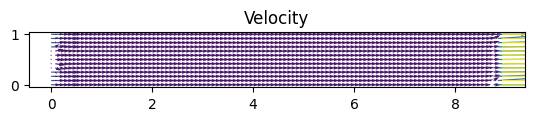

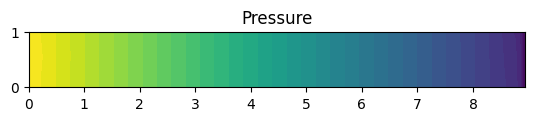

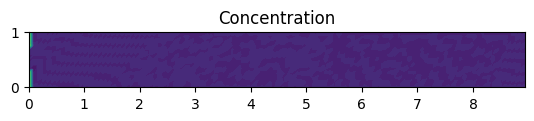

Time t = 0.2948245718897694


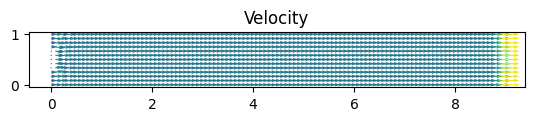

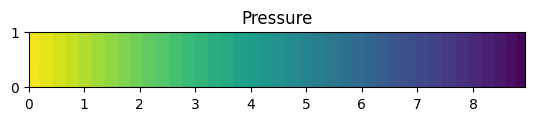

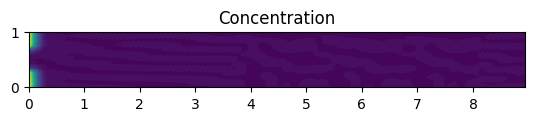

Time t = 0.5896491437795388


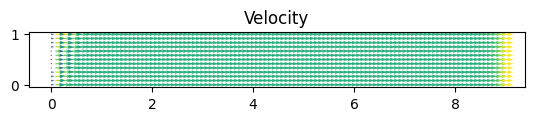

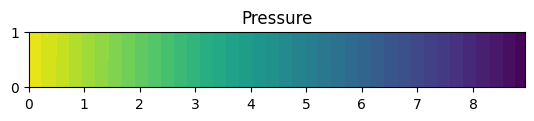

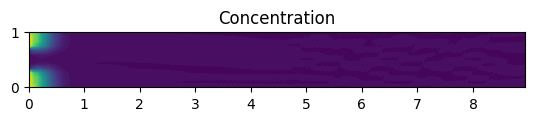

Time t = 0.8255088012913545


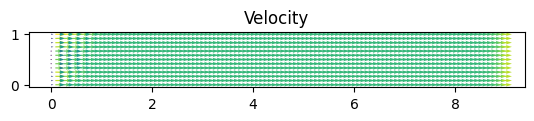

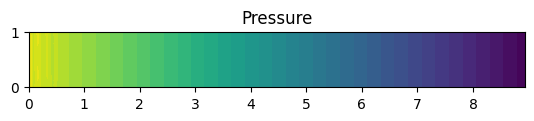

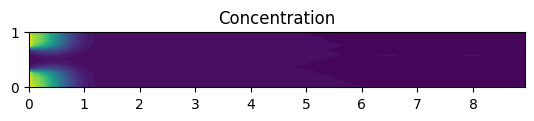

Time t = 1.1203333731811238


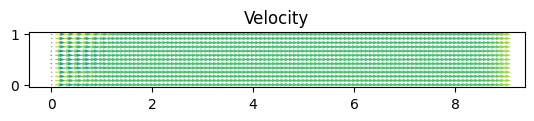

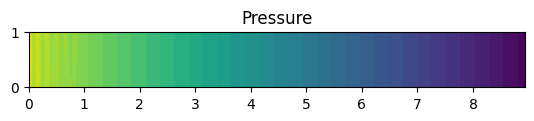

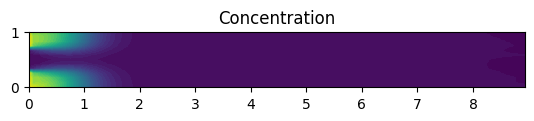

Time t = 1.356193030692939


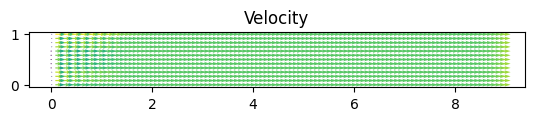

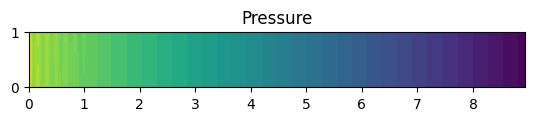

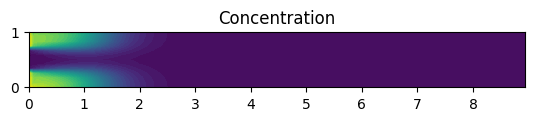

Time t = 1.6510176025827081


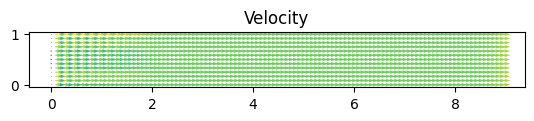

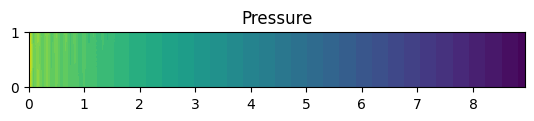

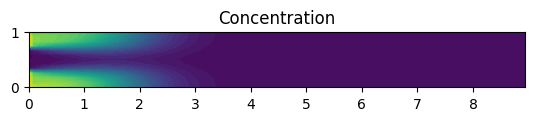

Time t = 1.8868772600945234


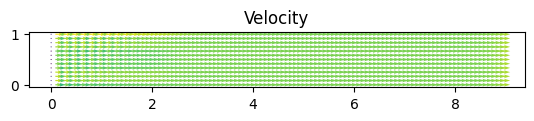

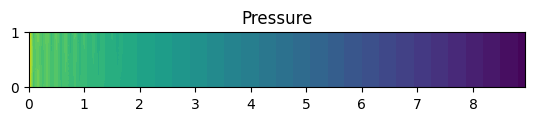

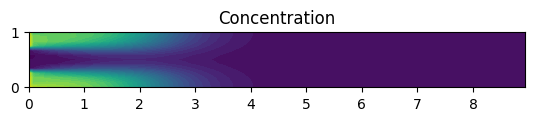

Time t = 2.1817018319842925


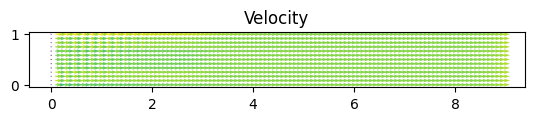

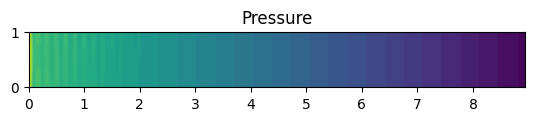

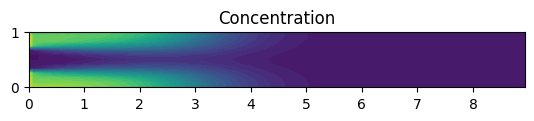

Time t = 2.4175614894961077


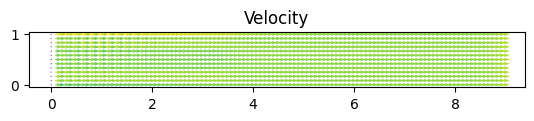

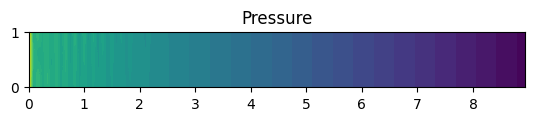

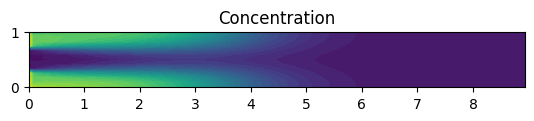

Time t = 2.712386061385877


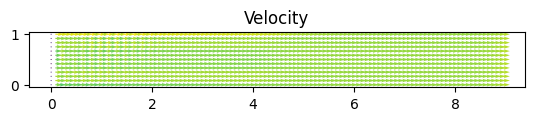

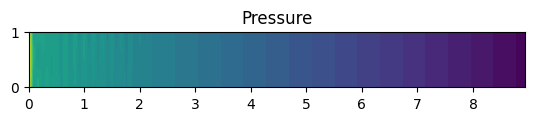

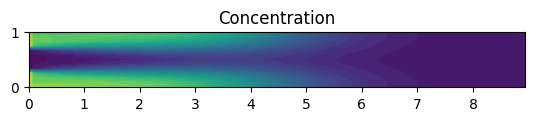

Time t = 2.948245718897692


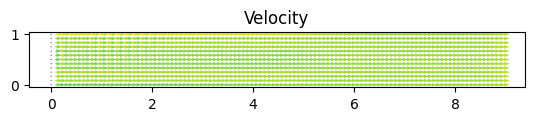

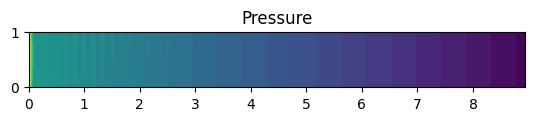

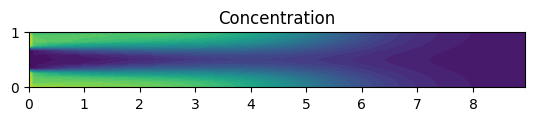

Time t = 3.243070290787461


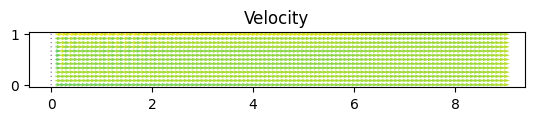

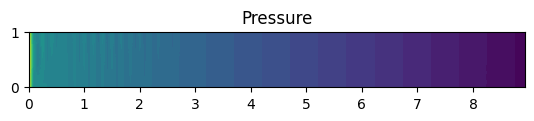

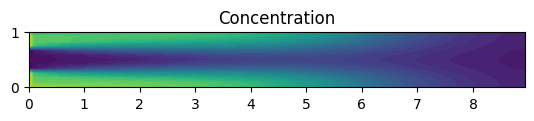

Time t = 3.4789299482992764


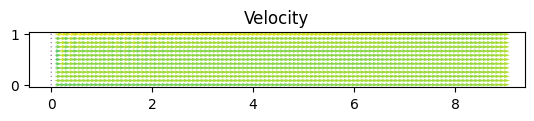

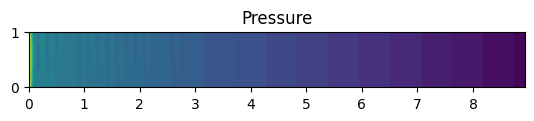

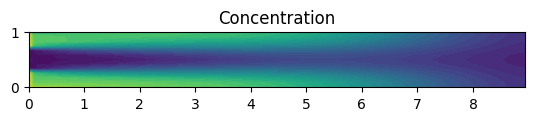

Time t = 3.7737545201890454


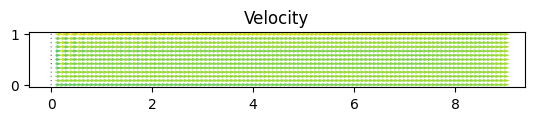

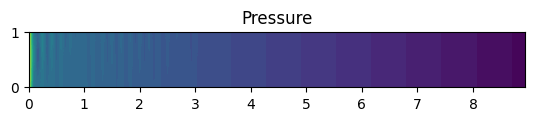

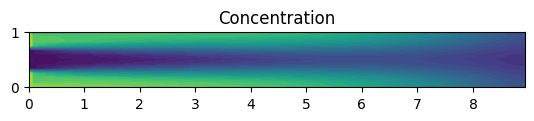

In [ ]:
!rm results-NS/*

# Time stepping
T = 4             # was at 20
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    #win.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Assemble temperature matrix and vector
        Aw = assemble(aw)
        bw = assemble(Lw)

        # Compute temperature solution
        [bc.apply(Aw, bw) for bc in bcw]
        [bc.apply(w1.vector()) for bc in bcw]
        solve(Aw, w1.vector(), bw, "bicgstab", prec)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1
        file_w << w1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        p_plot = plot(p1, title="Pressure")
        # Define colormap
        cmap = plt.cm.plasma  # Adjust as needed (e.g., "jet", "plasma")

        # Create colorbar with label
        #sm = plt.colorbar(p_plot, label='Pressure', orientation="horizontal")

        #plot(p1, title="Pressure")
        # Define colormap (choose a suitable one for pressure)
        #cmap = plt.cm.viridis  # Example colormap, adjust as needed
        # Create colorbar with label
        #sm = plt.colorbar(p_plot, label='Pressure')

        plt.figure()
        plot(w1, title="Concentration")

        plot_time += T/plot_freq

        plt.show()

    # Update time step
    u0.assign(u1)
    w0.assign(w1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve a heat convection-diffusion problem.